<a href="https://colab.research.google.com/github/kiennguyen-246/qaoa_sat/blob/main/qaoa_steiner_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Environment

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-catalog
!pip install python-dotenv
!pip install dimod
!pip install networkx
!pip install qiskit_aer
!pip install scipy
!pip install matplotlib
!pip install qiskit_algorithms
!pip install qiskit_qasm3_import
!pip install pylatexenc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import timeit
import math
import json
import numpy as np
from collections import defaultdict
from itertools import combinations, product
from pprint import pprint, pformat
from datetime import datetime
from zoneinfo import ZoneInfo

import networkx as nx
from matplotlib import pyplot as plt
import scipy
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2,
    Batch
)
from qiskit import qasm2, qasm3
from qiskit.circuit.library import QAOAAnsatz
from qiskit.providers import JobStatus
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.passes import HighLevelSynthesis, HLSConfig
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.optimizers import SPSA
from dotenv import load_dotenv
from dimod import BinaryQuadraticModel, ExactSolver, SPIN

In [ ]:
dotenv_path = '/content/drive/MyDrive/Colab Notebooks/QAOASteinerTree/.env'
load_dotenv(dotenv_path=dotenv_path,override=True)

channel_name = "ibm_quantum_platform"

print(os.getenv('QISKIT_API_KEY'))

try:
  QiskitRuntimeService.save_account(channel=channel_name,
                                  token=os.getenv('QISKIT_API_KEY'),
                                  overwrite=True)
  print("Account saved")
except:
  print("Account already exists. Skip adding account step")

service = QiskitRuntimeService(channel=channel_name)

EbpOzyy5RGz87zkEDFJ2kadUsbUbB4KvUjm1uSb6GI9Z
Account saved


qiskit_runtime_service.__init__:WARNING:2025-12-22 04:04:29,061: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [ ]:
# List all jobs (default limit is 10, set limit=None to get all)
jobs = service.jobs(limit=None)

## Utility functions

### QUBO

In [ ]:
def qubo_sum(q1=defaultdict, q2=defaultdict, size=0):
  """
  Add two QUBOs.
  """
  for (i, j) in q2:
    q1[(i, j)] += q2[(i, j)]
  return q1

def qubo_linear_mul(coef1=[], freeCoef1=0, coef2=[], freeCoef2=0, size=0, __lambda=1):
    """
    Multiply two linear terms.
    """
    q = defaultdict(int)
    for i in range(0, size):
        for j in range(0, size):
            if __lambda * coef1[i] * coef2[j] != 0:
                q[(i, j)] += __lambda * coef1[i] * coef2[j]
    for i in range(0, size):
        if __lambda * coef1[i] * freeCoef2 != 0:
            q[(i, i)] += __lambda * coef1[i] * freeCoef2
    for i in range(0, size):
        if __lambda * freeCoef1 * coef2[i] != 0:
            q[(i, i)] += __lambda * freeCoef1 * coef2[i]
    return {
        "q": q,
        "offset": __lambda * freeCoef1 * freeCoef2
    }

def qubo_linear_square(coef=[], freeCoef=0, size=0, __lambda=1):
    """
    Add a quadratic term to the QUBO.
    """
    q = defaultdict(int)
    for i in range(0, size):
        if __lambda * coef[i] ** 2 != 0:
            q[(i, i)] += __lambda * coef[i] ** 2
    for i in range(0, size):
        if __lambda * 2 * freeCoef * coef[i] != 0:
            q[(i, i)] += __lambda * 2 * freeCoef * coef[i]
    for (i, j) in combinations(range(0, size), 2):
        if __lambda * 2 * coef[i] * coef[j] != 0:
            q[(i, j)] += __lambda * 2 * coef[i] * coef[j]
    return {
        "q": q,
        "offset": __lambda * freeCoef ** 2
    }

def qubo_add_bitwise_or(q=defaultdict, size=0, x=0, y=0, z=0, __lambda=1):
    """
    Constraint: x | y = z
    Quadratic form: H = x^2 + y^2 + z^2 + xy - 2xz - 2yz
    """
    q[(x, x)] += __lambda
    q[(y, y)] += __lambda
    q[(z, z)] += __lambda
    q[(x, y)] += __lambda
    q[(x, z)] -= 2 * __lambda
    q[(y, z)] -= 2 * __lambda
    return q

def qubo_add_bitwise_or_exc_11(q=defaultdict, size=0, x=0, y=0, z=0, __lambda=1):
    """
    Constraint: x | y = z excluding x = 1, y = 1
    Quadratic form: H = x^2 + y^2 + z^2 + 2xy - 2xz - 2yz
    """
    q[(x, x)] += __lambda
    q[(y, y)] += __lambda
    q[(z, z)] += __lambda
    q[(x, y)] += 2 * __lambda
    q[(x, z)] -= 2 * __lambda
    q[(y, z)] -= 2 * __lambda
    return q

### QAOA utility functions

In [ ]:
def find_all_lowest_energy_solutions(bqm):
    sampler = ExactSolver()
    sampleset = sampler.sample(bqm)
    lowest_energy = sampleset.first.energy

    # Filter the solutions with the lowest energy
    lowest_energy_solutions = [sample for sample, energy in zip(sampleset.record['sample'], sampleset.record['energy'])
                               if energy == lowest_energy]

    # Convert solutions back to a dictionary format
    solution_dicts = [dict(enumerate(sol)) for sol in lowest_energy_solutions]
    print(solution_dicts)
    return solution_dicts, lowest_energy


def bqm_to_pauli_list(bqm: BinaryQuadraticModel):
  """
  Convert a BQM (Ising model) into a list of Pauli strings and coefficients.
  Args:
      bqm (dimod.BinaryQuadraticModel): The input BQM with spin variables.
  Returns:
      List of tuples: Each tuple contains a Pauli string (e.g., "IIIIZZ") and a coefficient (float).
  """
  num_variables = len(bqm.variables)
  sorted_variables = sorted(list(bqm.variables))
  pauli_list = []
  # Convert linear terms (h_i Z_i)
  for i, bias in bqm.linear.items():
      pauli_string = ['I'] * num_variables  # Start with all I's
      pauli_string[sorted_variables.index(i)] = 'Z'  # Apply Z at position i
      pauli_list.append((''.join(pauli_string), bias))
  # Convert quadratic terms (J_ij Z_i Z_j)
  for (i, j), bias in bqm.quadratic.items():
      pauli_string = ['I'] * num_variables  # Start with all I's
      pauli_string[sorted_variables.index(i)] = 'Z'  # Apply Z at position i
      pauli_string[sorted_variables.index(j)] = 'Z'  # Apply Z at position j
      pauli_list.append((''.join(pauli_string), bias))
  # Add the offset term
  if bqm.offset != 0:
      pauli_list.append(('I' * num_variables, bqm.offset))
  return pauli_list


def bqm_to_pauli_reverse(bqm: BinaryQuadraticModel):
  """
  Convert a BQM (Ising model) into a list of Pauli strings and coefficients.
  Args:
      bqm (dimod.BinaryQuadraticModel): The input BQM with spin variables.
  Returns:
      List of tuples: Each tuple contains a Pauli string (e.g., "IIIIZZ") and a coefficient (float).
  """
  num_variables = len(bqm.variables)
  sorted_variables = sorted(list(bqm.variables))
  pauli_list = []
  # Convert linear terms (h_i Z_i)
  for i, bias in bqm.linear.items():
      pauli_string = ['I'] * num_variables  # Start with all I's
      pauli_string[sorted_variables.index(i)] = 'Z'  # Apply Z at position i
      pauli_list.append((''.join(pauli_string)[::-1], bias))
  # Convert quadratic terms (J_ij Z_i Z_j)
  for (i, j), bias in bqm.quadratic.items():
      pauli_string = ['I'] * num_variables  # Start with all I's
      pauli_string[sorted_variables.index(i)] = 'Z'  # Apply Z at position i
      pauli_string[sorted_variables.index(j)] = 'Z'  # Apply Z at position j
      pauli_list.append((''.join(pauli_string)[::-1], bias))
  # Add the offset term
  if bqm.offset != 0:
      pauli_list.append(('I' * num_variables, bqm.offset))
  return pauli_list

def binary_string_to_spin_config(binary_string: str):
    """
    Convert a binary string to a spin configuration dictionary.

    Args:
        binary_string (str): A string of '0' and '1', e.g., '01001'.

    Returns:
       dict: A dictionary mapping variable index to spin value (-1 or +1).
    """
    return {i: 1 if bit == '1' else -1 for i, bit in enumerate(binary_string)}


def calculate_ising_energy(bqm: BinaryQuadraticModel, binary_string: str) -> float:
    """
    Calculate the energy of a BQM in Ising form given a binary string.

    Args:
        bqm (dimod.BinaryQuadraticModel): The BQM in Ising form (SPIN).
        binary_string (str): The binary string representing the state (e.g., '01001').

    Returns:
        float: The energy of the given binary string configuration in the Ising model.
    """
    # Convert the binary string to a spin configuration
    spin_config = binary_string_to_spin_config(binary_string)

    sorted_variables = sorted(list(bqm.variables))
    spin_config_dict = {}
    for i in range(0, len(sorted_variables)):
      spin_config_dict[sorted_variables[i]] = spin_config[i]

    # Calculate and return the energy for the spin configuration
    energy = bqm.energy(spin_config_dict)
    # print(binary_string, "->", energy)
    return energy

def calculate_enr_dis(distri, ising):
  nshot = sum(distri.values()) * 1.0
  enr_dis = dict()
  avg_enrgy = 0.0
  for k, v in distri.items():
    energy = calculate_ising_energy(ising, k[::-1])
    avg_enrgy += v * energy / nshot
    if energy in enr_dis:
        enr_dis[energy] += v / nshot
    else:
        enr_dis[energy] = v / nshot
  return enr_dis, avg_enrgy


### Miscellaneous

In [ ]:
def get_time():
  # Get the current time in UTC+7 time zone
  current_time = datetime.now(ZoneInfo("Asia/Bangkok"))
  return current_time.strftime("%d/%m/%Y %H:%M:%S UTC+7")

def log_msg(msg, level=1):
  match level:
    case 0:
      print(f"[{get_time()}][DEBUG] {msg}")
    case 1:
      print(f"[{get_time()}][INFO] {msg}")
    case 2:
      print(f"[{get_time()}][WARNING] {msg}")
    case 3:
      print(f"[{get_time()}][ERROR] {msg}")
    case 4:
      print(f"[{get_time()}][FATAL] {msg}")

# Model sovers

## Base solver

In [ ]:
class BQMSolutionSet:
  def __init__(self, bqm: BinaryQuadraticModel) -> None:
    self.bqm = bqm
    self.solver_method = ""
    self.solver_param_dict = {}
    self.circuit = ""
    self.circuit_info = {}
    self.full_result = None
    self.lowest_energy_solutions = []
    self.lowest_energy_params = []
    self.lowest_energy_rate = 0
    self.lowest_energy = 0
    self.optimal_energy = 0
    self.is_optimal = False
    self.avg_energy = 0
    self.enrergy_dist = {}
    self.run_time = 0
    self.time_to_solution = 0
    self.iters_ran = 0

  def to_dict(self):
    return {
        "bqm": self.bqm,
        "solver_method": self.solver_method,
        "solver_param_dict": self.solver_param_dict,
        "circuit": self.circuit,
        "circuit_info": self.circuit_info,
        "full_result": self.full_result,
        "lowest_energy_solutions": self.lowest_energy_solutions,
        "lowest_energy_params": self.lowest_energy_params,
        "lowest_energy_rate": self.lowest_energy_rate,
        "lowest_energy": self.lowest_energy,
        "optimal_energy": self.optimal_energy,
        "is_optimal": self.is_optimal,
        "avg_energy": self.avg_energy,
        "enrergy_dist": self.enrergy_dist,
        "run_time": self.run_time,
        "time_to_solution": self.time_to_solution,
        "iters_ran": self.iters_ran,
    }

In [ ]:
class BaseBQMSolver:
  def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0, use_real=False) -> None:
    self.bqm = bqm
    self.bqm_list = [bqm]
    self.use_real = use_real

    # Initialize QAOA solvers
    options = {"simulator": {"seed_simulator": 42}}
    noise_model = NoiseModel()
    self.simulator_backend = AerSimulator(method="statevector", noise_model=noise_model)
    self.simulator_sampler = SamplerV2(mode=self.simulator_backend, options=options)
    self.estimator = Estimator(mode=self.simulator_backend, options=options)

    self.real_backend = None
    self.real_sampler = None
    self.refresh_real_backend()

    self.optimal_energy = optimal_energy

  def solve(self, method, param_dict=None):
    raise NotImplementedError

  def make_candidate_circuit(self, bqm, nround=2, backend=None):
    paulis_list = bqm_to_pauli_list(bqm)
    cost_hamiltonian = SparsePauliOp.from_list(paulis_list)
    cost_reverse = SparsePauliOp.from_list(bqm_to_pauli_reverse(bqm))

    circuit = QAOAAnsatz(cost_operator=cost_reverse, reps=nround)
    # circuit.measure_all()
    run_backend = backend
    if backend is None:
      run_backend = self.simulator_backend
    candidate_circuit = None

    log_msg(f"Starting transpilation for {bqm.num_variables} qubits on backend {run_backend}")
    t_start = time.time()

    pm0 = generate_preset_pass_manager(optimization_level=0, backend=run_backend)
    original_circuit = pm0.run(circuit)

    # Use optimal circuit if the problem size is small enough (<= 20)
    # if bqm.num_variables <= 0:
    pm = generate_preset_pass_manager(optimization_level=3, backend=run_backend)
    candidate_circuit = pm.run(circuit)
    # Use Clifford greedy generated circuit if the problem size is large
    # else:
    #   optimization_level = 1
    #   # if bqm.num_variables <= 40:
    #   #   optimization_level = 3
    #   # hls_config = HLSConfig(
    #   #   clifford=[("synth_clifford_full", {"method": "greedy"})], # Good for large N
    #   #   linear_function=[("kms", {})], # Kutin-Moulton-Smithline (good for LNN)
    #   #   permutation=[("basic", {})]
    #   # )
    #   # basis_gates = run_backend.operation_names if hasattr(run_backend, "operation_names") else ["cx", "id", "rz", "sx", "x"]
    #   pm = generate_preset_pass_manager(
    #       optimization_level=optimization_level,
    #       backend=run_backend,
    #       # basis_gates=basis_gates,
    #       # hls_config=hls_config
    #   )
    #   candidate_circuit = pm.run(circuit)

    t_end = time.time()
    log_msg(f"Transpilation finished in {t_end - t_start:.2f}s")

    candidate_circuit.measure_all()
    return original_circuit, candidate_circuit

  def get_least_busy_backend(self):
    service = QiskitRuntimeService(channel=channel_name)
    candidate_backends = [
        b for b in service.backends()
        if b.configuration().n_qubits >= 127 and b.status().operational and not b.status().pending_jobs is None
    ]
    return sorted(candidate_backends, key=lambda b: b.status().pending_jobs)[0]

  def refresh_real_backend(self):
    new_real_backend = self.get_least_busy_backend()
    if self.real_backend is None or self.real_backend.name != new_real_backend.name:
      self.real_backend = new_real_backend
      self.real_sampler = SamplerV2(self.real_backend)
      self.real_sampler.options.dynamical_decoupling.enable = True
      self.real_sampler.options.twirling.enable_gates = True

  # Only solve one
  def solve_real_device(self, nround, bound_circuit):
    job = self.real_sampler.run([bound_circuit], shots=4000)

    log_msg(f"Submitted batch job to {self.real_backend.name} with job_id = {job.job_id()}")

    while not job.in_final_state():
      log_msg(f"Job status: {job.status()}")
      time.sleep(60)

    if job.errored():
      raise RuntimeError(f"[{get_time()}] Job {job.job_id()} errored: {job.error_message()}")

    log_msg(f"Job done")
    result = job.result()
    print(job.result)
    counts = result[0].data.meas.get_counts()
    return counts


## Exact solver (Using exhaustive search)

In [ ]:
class ExactBQMSolver(BaseBQMSolver):
  def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0):
    super().__init__(bqm, optimal_energy)

  def solve(self):
    sampler = ExactSolver()
    sampleset = sampler.sample(self.bqm)
    lowest_energy = sampleset.first.energy
    lowest_energy_solutions = [sample for sample, energy in zip(sampleset.record['sample'], sampleset.record['energy'])
                               if energy == lowest_energy]
    solution_dicts = [dict(enumerate(sol)) for sol in lowest_energy_solutions]

    solution_set = BQMSolutionSet(self.bqm)
    solution_set.solver_method = "ES"
    solution_set = BQMSolutionSet(self.bqm)
    solution_set.full_result = [dict(enumerate(sol)) for sol in lowest_energy_solutions]
    solution_set.lowest_energy_solutions = lowest_energy_solutions
    solution_set.lowest_energy = lowest_energy
    solution_set.lowest_energy_rate = len(lowest_energy_solutions) / len(sampleset.record['sample'])
    solution_set.avg_energy = sum(sampleset.record['energy']) / len(sampleset.record['sample'])
    solution_set.is_optimal = True
    # solution_set.enrergy_dist, solution_set.avg_energy = calculate_enr_dis(sampleset.record['sample'], self.bqm)

    return solution_set

## Simulated annealing solver

In [ ]:
# class SimulatedAnnealingSolver(BaseBQMSolver):
#   def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0):
#     super().__init__(bqm, optimal_energy)

#   def solve(self):
#     sampler = ExactSolver()
#     sampleset = sampler.sample(self.bqm)
#     lowest_energy = sampleset.first.energy
#     lowest_energy_solutions = [sample for sample, energy in zip(sampleset.record['sample'], sampleset.record['energy'])
#                                if energy == lowest_energy]
#     solution_dicts = [dict(enumerate(sol)) for sol in lowest_energy_solutions]

#     solution_set.solver_method = "ES"
#     solution_set = BQMSolutionSet(self.bqm)
#     solution_set.full_result = [dict(enumerate(sol)) for sol in lowest_energy_solutions]
#     solution_set.lowest_energy_solutions = lowest_energy_solutions
#     solution_set.lowest_energy = lowest_energy
#     solution_set.lowest_energy_rate = len(lowest_energy_solutions) / len(sampleset.record['sample'])
#     solution_set.avg_energy = sum(sampleset.record['energy']) / len(sampleset.record['sample'])
#     solution_set.is_optimal = True
#     # solution_set.enrergy_dist, solution_set.avg_energy = calculate_enr_dis(sampleset.record['sample'], self.bqm)

#     return solution_set

## QAOA Grid Search Solver

In [ ]:
class QAOAGridSearchBQMSolver(BaseBQMSolver):
  def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0, use_real=False):
    super().__init__(bqm, optimal_energy, use_real)

  def solve(self, param_dict=None):
    nround = 2
    if param_dict is not None:
      if "nround" in param_dict:
        nround = param_dict["nround"]
    log_msg(f"Starting QAOA with {nround} layers of optimizers, using COBYLA")
    original_circuit, candidate_circuit = self.make_candidate_circuit(self.bqm, nround=nround)

    grid_size = 9
    angle_grid = [np.linspace(0, np.pi, grid_size)] * (2 * nround)
    tested_angles = []
    circuits = []
    for param_combination in product(*angle_grid):
      tested_angles.append(param_combination)
      circuits.append(candidate_circuit.assign_parameters(param_combination))

    # Method 1: sample_avg_costs (sequential)
    grid_counts_list = []
    sample_avg_costs = []
    start_time = timeit.default_timer()
    with Batch(backend=self.simulator_backend):
      for params in tested_angles:
        bound = candidate_circuit.assign_parameters(params)
        result = self.simulator_sampler.run([bound], shots=4000).result()
        counts = result[0].data.meas.get_counts()
        total = sum(counts.values())
        avg_energy = sum(calculate_ising_energy(self.bqm, k[::-1]) * v / total for k, v in counts.items())
        sample_avg_costs.append(avg_energy)
        grid_counts_list.append(counts)
    end_time = timeit.default_timer()
    time_eplapsed = end_time - start_time
    # Identify best configuration
    best_idx = int(np.argmin(sample_avg_costs))
    # best_params = tested_angles[best_idx]
    # best_energy = sample_avg_costs[best_idx]

    grid_counts = grid_counts_list[best_idx]
    solution_set = BQMSolutionSet(self.bqm)
    solution_set.solver_method = "QAOA_GS"
    solution_set.solver_param_dict = param_dict
    solution_set.circuit_info = {
      "optimization_level": 3,
      "num_qubits": candidate_circuit.num_qubits,
      "depth": candidate_circuit.depth(),
      "gate_counts": candidate_circuit.count_ops()
    }

    solution_set.full_result = grid_counts
    solution_set.lowest_energy = min([calculate_ising_energy(self.bqm, k[::-1]) for k, _ in grid_counts.items()])
    solution_set.lowest_energy_params = list(tested_angles[best_idx])
    solution_set.lowest_energy_solutions = [binary_string_to_spin_config(k[::-1]) for k, _ in grid_counts.items() if calculate_ising_energy(self.bqm, k[::-1]) == solution_set.lowest_energy]
    solution_set.lowest_energy_rate = len(solution_set.lowest_energy_solutions) / len(grid_counts)
    solution_set.optimal_energy = self.optimal_energy

    data_dict1, _ = calculate_enr_dis(grid_counts, self.bqm)
    solution_set.enrergy_dist = data_dict1

    solution_set.avg_energy = sample_avg_costs[best_idx]
    # solution_set.enrergy_dist = data_dict1
    solution_set.run_time = time_eplapsed
    solution_set.iters_ran = grid_size ** (2 * nround)
    # solution_set.time_to_solution = time_eplapsed
    if solution_set.lowest_energy <= self.optimal_energy:
      solution_set.is_optimal = True

    return solution_set

## QAOA SPSA Solver

In [ ]:
class QAOASPSASolver(BaseBQMSolver):
  def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0, use_real=False):
    super().__init__(bqm, optimal_energy, use_real)

  def solve(self, param_dict=None):
    nround = 2
    if param_dict is not None:
      if "nround" in param_dict:
        nround = param_dict["nround"]
    log_msg(f"Starting QAOA with {nround} layers of optimizers, using COBYLA")

    # ratios = []
    # lambda1 = 1
    seed = 42
    x0 = [np.pi / 3] * (2 * nround)

    original_circuit, candidate_circuit = self.make_candidate_circuit(self.bqm, nround=nround)

    spsa_angles = []
    spsa = SPSA(maxiter=param_dict["maxiter"])
    # spsa = SPSA(maxiter=1000,
    #             learning_rate=0.1,  # Step size 'a'
    #             perturbation=0.3,  # Perturbation size 'c'
    #             # blocking=True,  # Only accept if step improves
    #             allowed_increase=0.01,  # Allow very small increase
    #             trust_region=True,  # Prevent large jumps
    #             # second_order=True  # Approximate second order information (quasi-Newton)
    #             )  # You can tune these hyperparameters

    def cost_function_22(params, circuit, ising, sampler, debug=False):
      spsa_angles.append(params)
      bound_circuit = circuit.assign_parameters(params)
      nshot = 4000
      result = sampler.run([bound_circuit], shots=nshot).result()
      counts = result[0].data.meas.get_counts()
      # if debug:
      #     print(counts, file=sys.stderr)
      avg_energy = 0.0
      sum = 0.0
      for k, v in counts.items():
          sum += v
      for k, v in counts.items():
          avg_energy += calculate_ising_energy(ising, k[::-1]) * v / sum
      # print(params, avg_energy)
      return avg_energy

    def spsa_cost_func(params):
        return cost_function_22(params, candidate_circuit, self.bqm, self.simulator_sampler)
    result = spsa.minimize(fun=spsa_cost_func, x0=x0)
    opt_params = result.x
    print("Best angle by SPSA", opt_params, "Search len:", len(spsa_angles))

    start = timeit.default_timer()
    with Batch(backend=self.simulator_backend):
      bound_circuit = candidate_circuit.assign_parameters(result.x)
      result_ = self.simulator_backend.run(bound_circuit, shots=4000).result()
      spsa_counts = result_.get_counts()
    end = timeit.default_timer()
    time_eplapsed = end - start

    data_dict1, enr1 = calculate_enr_dis(spsa_counts, self.bqm)
    # print(data_dict1)

    solution_set = BQMSolutionSet(self.bqm)
    solution_set.solver_method = "QAOA_SPSA"
    solution_set.solver_param_dict = param_dict
    solution_set.full_result = spsa_counts
    solution_set.circuit = qasm3.dumps(bound_circuit)
    solution_set.circuit_info = {
      "optimization_level": 3,
      "num_qubits": candidate_circuit.num_qubits,
      "depth": candidate_circuit.depth(),
      "gate_counts": candidate_circuit.count_ops()
    }

    solution_set.lowest_energy = min([calculate_ising_energy(self.bqm, k[::-1]) for k, _ in spsa_counts.items()])
    solution_set.lowest_energy_solutions = [binary_string_to_spin_config(k[::-1]) for k, _ in spsa_counts.items() if calculate_ising_energy(self.bqm, k[::-1]) == solution_set.lowest_energy]
    solution_set.lowest_energy_params = list(result.x)
    solution_set.lowest_energy_rate = len(solution_set.lowest_energy_solutions) / len(spsa_counts)
    solution_set.optimal_energy = self.optimal_energy

    solution_set.avg_energy = enr1
    solution_set.enrergy_dist = data_dict1
    solution_set.run_time = time_eplapsed
    solution_set.iters_ran = result.nfev
    # solution_set.time_to_solution = time_eplapsed
    if solution_set.lowest_energy <= self.optimal_energy:
      solution_set.is_optimal = True

    return solution_set

## QAOA COBYLA Solver

In [ ]:
class QAOACOBYLABQMSolver(BaseBQMSolver):
  def __init__(self, bqm: BinaryQuadraticModel, optimal_energy=0, use_real=False):
    super().__init__(bqm, optimal_energy, use_real)
  def solve(self, param_dict=None):
    nround = 2
    if param_dict is not None:
      if "nround" in param_dict:
        nround = param_dict["nround"]
    log_msg(f"Starting QAOA with {nround} layers of optimizers, using COBYLA")
    if self.use_real and len(self.bqm.variables) > 20:
      self.refresh_real_backend()
      original_cỉcuit, candidate_circuit = self.make_candidate_circuit(self.bqm, nround=nround, backend=self.real_backend)
    else:
      original_cỉcuit, candidate_circuit = self.make_candidate_circuit(self.bqm, nround=nround)
    init_params = [np.pi / 3] * (2 * nround)
    cobyla_angles = []

    def cost_function_22(params, circuit, qaoa_solver, debug=False):
      cobyla_angles.append(params)
      bound_circuit = candidate_circuit.assign_parameters(params)

      counts = None
      if qaoa_solver.use_real and len(self.bqm.variables) > 20:
        counts = qaoa_solver.solve_real_device(nround, bound_circuit)
      else:
        result = qaoa_solver.simulator_sampler.run([bound_circuit], shots=4000).result()
        counts = result[0].data.meas.get_counts()
      # print(counts)
      total = sum(counts.values())
      avg_energy = sum(calculate_ising_energy(qaoa_solver.bqm, k[::-1]) * v / total for k, v in counts.items())
      # print(avg_energy)
      return avg_energy

    cobyla_options = {}
    if param_dict is not None:
      if "tol" in param_dict:
        cobyla_options["tol"] = param_dict["tol"]
      if "maxiter" in param_dict:
        cobyla_options["maxiter"] = param_dict["maxiter"]
    if self.use_real and len(self.bqm.variables) > 20:
      cobyla_options["maxiter"] = 5

    start = timeit.default_timer()
    result = scipy.optimize.minimize(
      cost_function_22, init_params,
      args=(candidate_circuit, self),
      method="COBYLA",  # , tol=1e-4
      options=cobyla_options
    )

    bound_circuit = None
    if self.use_real:
      if len(self.bqm.variables) <= 20:
        self.refresh_real_backend()
        _, candidate_circuit = self.make_candidate_circuit(self.bqm, nround=nround, backend=self.real_backend)
      bound_circuit = candidate_circuit.assign_parameters(result.x)
      cobyla_counts = self.solve_real_device(nround, bound_circuit)
    else:
      with Batch(backend=self.simulator_backend):
        bound_circuit = candidate_circuit.assign_parameters(result.x)
        result_ = self.simulator_backend.run(bound_circuit, shots=4000).result()
        cobyla_counts = result_.get_counts()
    end = timeit.default_timer()
    time_eplapsed = end - start

    data_dict1, enr1 = calculate_enr_dis(cobyla_counts, self.bqm)
    # print(data_dict1)

    solution_set = BQMSolutionSet(self.bqm)
    solution_set.solver_method = "QAOA_COBYLA"
    solution_set.solver_param_dict = param_dict
    solution_set.full_result = cobyla_counts
    solution_set.circuit = qasm3.dumps(bound_circuit)
    solution_set.circuit_info = {
      "optimization_level": 3,
      "num_qubits": candidate_circuit.num_qubits,
      "depth": candidate_circuit.depth(),
      "gate_counts": candidate_circuit.count_ops()
    }
    solution_set.lowest_energy = min([calculate_ising_energy(self.bqm, k[::-1]) for k, _ in cobyla_counts.items()])
    solution_set.lowest_energy_solutions = [binary_string_to_spin_config(k[::-1]) for k, _ in cobyla_counts.items() if calculate_ising_energy(self.bqm, k[::-1]) == solution_set.lowest_energy]
    solution_set.lowest_energy_params = list(result.x)
    solution_set.lowest_energy_rate = len(solution_set.lowest_energy_solutions) / len(cobyla_counts)
    solution_set.optimal_energy = self.optimal_energy

    solution_set.avg_energy = enr1
    solution_set.enrergy_dist = data_dict1
    solution_set.run_time = time_eplapsed
    solution_set.iters_ran = result.nfev
    # solution_set.time_to_solution = time_eplapsed
    if solution_set.lowest_energy <= self.optimal_energy:
      solution_set.is_optimal = True

    return solution_set

# Solve the problem using formulations


## Base Formulation

In [ ]:
class BaseFormulation:
  def __init__(self) -> None:
    self.var_map = {}
    self.var_cnt = 0
    self.fixed_vars = []
    self.var_cnt_2 = 0    # use if there are fixed variables
    self.var_map_2 = {}   # use if there are fixed variables
    self.constraints = [] # in QUBO form
    self.constraint_ext_coef = []

    self.method = ""

  def add_var(self, var_name):
    self.var_map[var_name] = self.var_cnt
    self.var_cnt += 1
    return self.var_map[var_name]

  def add_var_2(self, var_name):
    self.var_map_2[var_name] = self.var_cnt_2
    self.var_cnt_2 += 1
    return self.var_map_2[var_name]

  def solve_bqm(self, bqm, optimal_energy, param_dict=None, use_real_device=False):
    """
    Solve the formulation using a BQM solver
    """
    exact_solver = ExactBQMSolver(bqm, optimal_energy)
    qaoa_grid_search_solver = QAOAGridSearchBQMSolver(bqm, optimal_energy, use_real_device)
    qaoa_spsa_solver = QAOASPSASolver(bqm, optimal_energy, use_real_device)
    qaoa_cobyla_solver = QAOACOBYLABQMSolver(bqm, optimal_energy, use_real_device)

    print(self.method)

    if "ES" in self.method:
      return exact_solver.solve()
    if "QAOA_GS" in self.method:
      return qaoa_grid_search_solver.solve(param_dict)
    if "QAOA_SPSA" in self.method:
      return qaoa_spsa_solver.solve(param_dict)
    if "QAOA_COBYLA" in self.method:
      return qaoa_cobyla_solver.solve(param_dict)
    raise NotImplementedError

  def init_constraints(self):
    """
    Initialize the constraints
    """
    raise NotImplementedError

  def solve(self) -> tuple[list, float]:
    """
    The base solver for any formulations
    """
    raise NotImplementedError

  def is_answer(self, sample) -> bool:
    """
    Check if the sample is the answer
    :param sample: The sample from the solver
    :param input_dict: The input for the solver
    :return: True if the sample is the answer
    """
    for i in range(1, len(self.constraints)):
      if not self.is_constraint_satisfied(i, sample):
        return False
    return True

  def is_constraint_satisfied(self, constraint_id, sample):
    """
    Check if a sample satisfies the constraint
    :param constraint: The constraint, in {qubo:defaultdict, offset} form
    :param sample: The sample to check
    :return: True if the sample satisfies the constraint
    """
    return self.constraint_penalty(constraint_id, sample) == 0

  def constraint_penalty(self, constraint_id, sample):
    """
    Calculate the penalty for a sample violating a constraint
    :param constraint: The constraint, in {qubo:defaultdict, offset} form
    :param sample: The sample to check
    :return: The penalty
    """
    constraint_qubo = self.constraints[constraint_id]["q"]
    constraint_offset = self.constraints[constraint_id]["offset"]
    for var_id in self.var_map.keys():
      if constraint_qubo[self.var_map[var_id], self.var_map[var_id]] == 0:
        constraint_qubo[self.var_map[var_id], self.var_map[var_id]] = 0
    bqm = BinaryQuadraticModel.from_qubo(constraint_qubo, constraint_offset)
    for var_id in self.var_map.keys():
      if var_id in self.fixed_vars:
        bqm.fix_variable(v=self.var_map[var_id], value=1)

    sorted_variables = sorted(list(bqm.variables))
    sample_dict = {}
    for i in range(0, len(sorted_variables)):
      sample_dict[sorted_variables[i]] = int(sample[i])
    return bqm.energy(sample_dict)

  def model_energy(self, sample):
    """
    Calculate the energy of a sample
    :param sample: The sample to calculate the energy for
    :return: The energy
    """
    q = defaultdict(int)
    offset = 0
    for i in range(len(self.constraints)):
      q = qubo_sum(q1=q, q2=self.constraints[i]["q"], size=len(self.var_map))
      offset += self.constraints[i]["offset"]
    log_msg(f"QUBO: {q}")
    bqm = BinaryQuadraticModel.from_qubo(q, offset)
    for var_id in self.var_map.keys():
      if var_id in self.fixed_vars:
        bqm.fix_variable(v=self.var_map[var_id], value=1)

    sorted_variables = sorted(list(bqm.variables))
    sample_dict = {}
    for i in range(0, len(sorted_variables)):
      sample_dict[sorted_variables[i]] = int(sample[i])
    return bqm.energy(sample_dict)

## Fowler's Formulation for Steiner Tree (StTopo)

In [ ]:
class FowlerFormulation(BaseFormulation):
  def __init__(self, g, terminals, root=0,
               constraint_ext_coef=None,
               bqm_solving_method="",
               optimal_energy=0) -> None:
    super().__init__()

    # Create variables
    self.method += "StTopo"
    self.g = g
    self.terminals = terminals
    self.root = root
    self.terminals.append(root)

    self.bqm_solving_method = bqm_solving_method
    self.method += bqm_solving_method
    self.constraint_ext_coef= constraint_ext_coef
    if constraint_ext_coef == None:
      self.constraint_ext_coef = [1, 1, 1, 1, 1, 1]

    self.optimal_energy = optimal_energy

  def solve(self) -> tuple[None, int, BQMSolutionSet]:
    n = len(self.g.nodes)

    g1 = nx.DiGraph()
    for (u, v) in list(self.g.edges):
      if u != self.root and v != self.root:
        g1.add_edge(u, v, weight=self.g[u][v]['weight'])
        g1.add_edge(v, u, weight=self.g[u][v]['weight'])
    for u in list(self.g.nodes):
      if u != self.root and (self.root, u) in list(self.g.edges):
        g1.add_edge(self.root, u)
    print(g1.edges)

    edge_list_root_sepc = list(filter(lambda x: x[1] != self.root, list(g1.edges)))
    print(edge_list_root_sepc)

    # Initialize variables
    for (u, v) in edge_list_root_sepc:
      self.add_var(("e", u, v))
    for u in range(0, n):
      for v in range(u + 1, n):
        if u != self.root and v != self.root:
          self.add_var(("x", u, v))
    print(self.var_map)

    # Generate QUBO
    q = defaultdict(int)
    qSize = len(self.var_map)
    offset = 0

    def get(var_name, u, v):
      return self.var_map[(var_name, u, v)]

    def objective():
        """See paper"""
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[0]
        for (u, v) in edge_list_root_sepc:
            q[(get("e", u, v), get("e", u, v))] += ext_coef * self.g[u][v]['weight']

        return {
            "q": q,
            "offset": offset
        }

    def constraint1():
        """
        Vertices must be in the correct order: \
        x[u][v] = 0 && x[v][w] = 0 => x[u][w] = 0 \
        x[u][v] = 0 && x[v][w] = 1 => x[u][w] = 0 \
        x[u][v] = 0 && x[v][w] = 1 => x[u][w] = 1 \
        x[u][v] = 1 && x[v][w] = 0 => x[u][w] = 0 \
        x[u][v] = 1 && x[v][w] = 0 => x[u][w] = 1 \
        x[u][v] = 1 && x[v][w] = 1 => x[u][w] = 1 \
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[1]
        for u in range(0, n):
            for v in range(u + 1, n):
                for w in range(v + 1, n):
                    if (u == self.root or v == self.root or w == self.root): continue
                    q[(get("x", u, w), get("x", u, w))] += ext_coef
                    q[(get("x", u, v), get("x", v, w))] += ext_coef
                    q[(get("x", u, v), get("x", u, w))] -= ext_coef
                    q[(get("x", u, w), get("x", v, w))] -= ext_coef
        return {
            "q": q,
            "offset": offset
        }

    def constraint2():
        """
        If edge (u, v) exist in the DAG, its topology order must be correct:
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[2]
        for (u, v) in edge_list_root_sepc:
            if (u >= v): continue
            if (u == self.root or v == self.root): continue
            q[(get("e", u, v), get("e", u, v))] += ext_coef
            q[(get("e", u, v), get("x", u, v))] -= ext_coef
            q[(get("e", v, u), get("x", u, v))] += ext_coef
        return {
            "q": q,
            "offset": offset
        }

    def constraint3():
        """
        Non-root terminals must have exactly 1 incoming edge
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[3]
        for v in self.terminals:
            if (v == self.root): continue
            coef2 = [0] * qSize
            for u in g.adj[v]:
                coef2[get("e", u, v)] += 1
            q_sq = qubo_linear_square(coef=coef2,
                                    freeCoef=-1,
                                    size=qSize,
                                    __lambda=ext_coef)
            q = qubo_sum(q1=q, q2=q_sq["q"], size=qSize)
            offset += q_sq["offset"]
        return {
            "q": q,
            "offset": offset
        }

    def constraint4():
        """
        Non-terminals must have no more than 1 incoming edge
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[4]
        for v in range(0, n):
            if v in self.terminals:
                continue
            for u in g.adj[v]:
                for w in g.adj[v]:
                    if u == w:
                        continue
                    q[(get("e", u, v), get("e", w, v))] += ext_coef
        return {
            "q": q,
            "offset": offset
        }

    def constraint5():
        """
        Non-terminals cannot be DAG root
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[5]
        for v in range(0, n):
            if v in self.terminals:
                continue
            coef1 = [0] * qSize
            coef2 = [0] * qSize
            for u in g.adj[v]:
                coef1[get("e", u, v)] -= 1
            freeCoef1 = 1
            for u in g.adj[v]:
                if (u == self.root): continue
                coef2[get("e", v, u)] += 1
            q_mul = qubo_linear_mul(coef1=coef1,
                                 freeCoef1=freeCoef1,
                                 coef2=coef2,
                                 size=qSize,
                                 __lambda=ext_coef)
            q = qubo_sum(q1=q, q2=q_mul["q"], size=qSize)
            offset += q_mul["offset"]
        return {
            "q": q,
            "offset": offset
        }

    # Add constraints and objective function to the QUBO
    q = qubo_sum(q1=q, q2=constraint1()["q"], size=qSize)
    offset += constraint1()["offset"]
    q = qubo_sum(q1=q, q2=constraint2()["q"], size=qSize)
    offset += constraint2()["offset"]
    q = qubo_sum(q1=q, q2=constraint3()["q"], size=qSize)
    offset += constraint3()["offset"]
    q = qubo_sum(q1=q, q2=constraint4()["q"], size=qSize)
    offset += constraint4()["offset"]
    q = qubo_sum(q1=q, q2=constraint5()["q"], size=qSize)
    offset += constraint5()["offset"]
    q = qubo_sum(q1=q, q2=objective()["q"], size=qSize)
    offset += objective()["offset"]

    bqm = BinaryQuadraticModel.from_qubo(q, offset)
    bqm = bqm.change_vartype(SPIN)
    print(bqm)

    solution_set = self.solve_bqm(bqm, self.optimal_energy)
    pprint(solution_set.to_dict())

    qubo_sol = [(solution_set.lowest_energy_solutions[0][i] + 1) / 2 for i in range(self.var_cnt)]
    print(qubo_sol)

    res_g = nx.Graph()
    for var_id in self.var_map.keys():
      if var_id[0] == "e":
        if qubo_sol[self.var_map[var_id]] == 1:
          res_g.add_edge(var_id[1], var_id[2])

    return res_g, solution_set.lowest_energy, solution_set

## Hoang et al's formulation for Steiner Tree (StTopoReduce)


In [ ]:
class HoangFormulation(BaseFormulation):
  def __init__(self, g, terminals, root=0,
               constraint_ext_coef=None,
               bqm_solving_method="",
               bqm_solver_param_dict=None,
               optimal_energy=0,
               use_real_device=False) -> None:
    super().__init__()

    # Create variables
    self.method += "StTopoReduce"
    self.g = g
    self.terminals = terminals
    self.root = root
    self.terminals.append(root)

    self.bqm_solving_method = bqm_solving_method
    self.bqm_solver_param_dict = bqm_solver_param_dict
    self.method += bqm_solving_method
    self.constraints = []
    self.constraint_ext_coef= constraint_ext_coef
    if constraint_ext_coef == None:
      self.constraint_ext_coef = [1, 1, 1, 1, 1, 1]

    self.optimal_energy = optimal_energy

    self.use_real_device = use_real_device

  def init_constraints(self):
    n = len(self.g.nodes)
    print(self.root)

    g1 = nx.DiGraph()
    for (u, v) in list(self.g.edges):
      # if u != self.root and v != self.root:
        g1.add_edge(u, v, weight=self.g[u][v]['weight'])
        g1.add_edge(v, u, weight=self.g[u][v]['weight'])
    # for u in list(self.g.nodes):
    #   if u != self.root and (self.root, u) in list(self.g.edges):
    #     g1.add_edge(self.root, u)
    print(g1.edges)

    edge_list_root_sepc = list(filter(lambda x: x[1] != self.root, list(g1.edges)))
    print(edge_list_root_sepc)

    # Initialize variables
    for (u, v) in edge_list_root_sepc:
      self.add_var(("e", u, v))
    for u in range(0, n):
      for v in range(u + 1, n):
        if u != self.root and v != self.root:
          self.add_var(("x", u, v))
    for v in g1.nodes:
      if v in self.terminals and v == self.root:
        continue
      adj = list(g1.adj[v])
      for i in range(1, len(adj)):
        self.add_var(("s", v, i))
      if self.root in adj:
        adj.remove(self.root)
      for i in range(1, len(adj)):
        if v not in self.terminals and i != len(adj) - 1:
          self.add_var(("t", v, i))
    print(self.var_map)
    self.fixed_vars = []
    for v in self.terminals:
      if v != self.root:
        adj = list(g1.adj[v])
        if len(g1.adj[v]) == 1:
          self.fixed_vars.append(("e", adj[0], v))
        else:
          self.fixed_vars.append(("s", v, len(adj) - 1))
    log_msg(f"Fixed variables: {self.fixed_vars}")

    # Generate QUBO
    def get(var_name, u, v):
      return self.var_map[(var_name, u, v)]

    def objective():
        """See paper"""
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[0]
        for (u, v) in edge_list_root_sepc:
            q[(get("e", u, v), get("e", u, v))] += ext_coef * self.g[u][v]['weight']

        return {
            "q": q,
            "offset": offset
        }

    def constraint1():
        """
        Vertices must be in the correct order: \
        x[u][v] = 0 && x[v][w] = 0 => x[u][w] = 0 \
        x[u][v] = 0 && x[v][w] = 1 => x[u][w] = 0 \
        x[u][v] = 0 && x[v][w] = 1 => x[u][w] = 1 \
        x[u][v] = 1 && x[v][w] = 0 => x[u][w] = 0 \
        x[u][v] = 1 && x[v][w] = 0 => x[u][w] = 1 \
        x[u][v] = 1 && x[v][w] = 1 => x[u][w] = 1 \
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[1]
        for u in range(0, n):
            for v in range(u + 1, n):
                for w in range(v + 1, n):
                    if (u == self.root or v == self.root or w == self.root): continue
                    q[(get("x", u, w), get("x", u, w))] += ext_coef
                    q[(get("x", u, v), get("x", v, w))] += ext_coef
                    q[(get("x", u, v), get("x", u, w))] -= ext_coef
                    q[(get("x", u, w), get("x", v, w))] -= ext_coef
        return {
            "q": q,
            "offset": offset
        }

    def constraint2():
        """
        If edge (u, v) exist in the DAG, its topology order must be correct:
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[2]
        for (u, v) in edge_list_root_sepc:
            if (u >= v): continue
            if (u == self.root or v == self.root): continue
            q[(get("e", u, v), get("e", u, v))] += ext_coef
            q[(get("e", u, v), get("x", u, v))] -= ext_coef
            q[(get("e", v, u), get("x", u, v))] += ext_coef
        return {
            "q": q,
            "offset": offset
        }

    def constraint3():
        """
        Non-root terminals must have exactly 1 incoming edge
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[3]

        for v in self.terminals:
            if v == self.root:
                continue
            adj = list(g1.adj[v])
            if len(adj) <= 1:
                continue
            q = qubo_add_bitwise_or_exc_11(q=q, x=get("e", adj[0], v), y=get("e", adj[1], v), z=get("s", v, 1),
                                      __lambda=ext_coef)
            # print("s", v, 1)
            for i in range(2, len(adj)):
                q = qubo_add_bitwise_or_exc_11(q=q, x=get("s", v, i - 1), y=get("e", adj[i], v), z=get("s", v, i),
                                          __lambda=ext_coef)
                # print("s", v, i)
        return {
            "q": q,
            "offset": offset
        }

    def constraint4():
        """
        Non-terminals must have no more than 1 incoming edge
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[4]

        for v in g1.nodes:
            if v in self.terminals or v == self.root:
                continue
            adj = list(g1.adj[v])
            if len(adj) == 1:
                continue
            q = qubo_add_bitwise_or_exc_11(q=q, x=get("e", adj[0], v), y=get("e", adj[1], v), z=get("s", v, 1),
                                      __lambda=ext_coef)
            # print("s", v, 1)
            for i in range(2, len(adj)):
                q = qubo_add_bitwise_or_exc_11(q=q, x=get("s", v, i - 1), y=get("e", adj[i], v), z=get("s", v, i),
                                          __lambda=ext_coef)
                # print("s", v, i)
        return {
            "q": q,
            "offset": offset
        }

    def constraint5():
        """
        Non-terminals cannot be DAG root
        """
        q = defaultdict(int)
        offset = 0
        ext_coef = self.constraint_ext_coef[5]
        for v in g1.nodes:
            if v in self.terminals or v == self.root:
                continue
            adj = list(g1.adj[v])
            if self.root in adj:
                adj.remove(self.root)
            if len(adj) > 2:
                q = qubo_add_bitwise_or(q=q, x=get("e", v, adj[0]), y=get("e", v, adj[1]), z=get("t", v, 1),
                                   __lambda=ext_coef)
                # print("t", v, 1)
            elif len(adj) > 1:
                q = qubo_add_bitwise_or(q=q, x=get("e", v, adj[0]), y=get("e", v, adj[1]),
                                   z=get("s", v, len(adj) - 1),
                                   __lambda=ext_coef)
                # print("s", v, len(g1.adj[v]) - 1)
            # else:
            #     q = qubo_add_bitwise_or(q=q, x=get("e", v, adj[0]), y=get("e", v, adj[0]),
            #                        z=get("s", v, len(adj) - 1),
            #                        __lambda=ext_coef)
                # print("s", v, len(g1.adj[v]) - 1)
            for i in range(2, len(adj)):
                if i != len(adj) - 1:
                    q = qubo_add_bitwise_or(q=q, x=get("t", v, i - 1), y=get("e", v, adj[i]), z=get("t", v, i),
                                       __lambda=ext_coef)
                    # print("t", v, i)
                else:
                    q = qubo_add_bitwise_or(q=q, x=get("t", v, i - 1), y=get("e", v, adj[i]),
                                       z=get("s", v, len(adj) - 1),
                                       __lambda=ext_coef)
                    # print("s", v, len(g1.adj[v]) - 1)
        return {
            "q": q,
            "offset": offset
        }

    # Add constraints and objective function to the QUBO
    self.constraints = []
    self.constraints.append(objective())
    self.constraints.append(constraint1())
    self.constraints.append(constraint2())
    self.constraints.append(constraint3())
    self.constraints.append(constraint4())
    self.constraints.append(constraint5())

    # pprint(self.constraints)

  def solve(self) -> tuple[None, int, BQMSolutionSet]:
    self.init_constraints()

    q = defaultdict(int)
    qSize = len(self.var_map)
    offset = 0
    for i in range(len(self.constraints)):
      q = qubo_sum(q1=q, q2=self.constraints[i]["q"], size=len(self.var_map))
      offset += self.constraints[i]["offset"]
    log_msg(f"QUBO: {q}")
    bqm = BinaryQuadraticModel.from_qubo(q, offset)
    for var_id in self.var_map.keys():
      if var_id in self.fixed_vars:
        bqm.fix_variable(v=self.var_map[var_id], value=1)
      else:
        self.add_var_2(var_id)
    bqm = bqm.change_vartype(SPIN)
    log_msg(f"Variables used in BQM: {self.var_map_2}")
    log_msg(f"BQM created: {bqm}")
    log_msg(f"{len(bqm.variables)} qubits, {bqm.num_interactions} interactions")

    solution_set = self.solve_bqm(bqm, self.optimal_energy, self.bqm_solver_param_dict, self.use_real_device)
    pprint(solution_set.to_dict())

    qubo_sol = [(solution_set.lowest_energy_solutions[0][i] + 1) / 2 for i in range(self.var_cnt_2)]
    print(qubo_sol)

    res_g = nx.Graph()
    for var_id in self.var_map.keys():
      if var_id[0] == "e":
        if var_id not in self.var_map_2.keys():
          res_g.add_edge(var_id[1], var_id[2])
        else:
          if qubo_sol[self.var_map_2[var_id]] == 1:
            res_g.add_edge(var_id[1], var_id[2])

    return res_g, solution_set.lowest_energy, solution_set

# Experiments

## Input

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/QAOASteinerTree")
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/QAOASteinerTree


In [ ]:
# Quick hardcoded graph definition

# g = nx.Graph()

# # 0 1 5
# # 1 2 10
# # 0 3 2
# # 3 2 20

# g.add_edge(0, 1, weight=5)
# g.add_edge(1, 2, weight=10)
# g.add_edge(0, 3, weight=2)
# g.add_edge(3, 2, weight=20)

# terminals = [0, 1, 2]

In [ ]:
input_dir = "steiner_inp"
print(f"Reading files from input directory {input_dir}")
input_list = []

for input_file in os.listdir(input_dir):
  if ".inp" not in input_file:
    continue
  if "opt" in input_file:
    continue
  g = nx.Graph()
  with open(os.path.join(input_dir, input_file), "r") as f:
    # read first line to get the number of vertices, edges and number of terminals
    num_vertices, num_edges, num_terminals = map(int, f.readline().split())
    # for each line in the next m lines get u, v, w, then add an edge from u and v, weight = w
    for _ in range(num_edges):
      u, v, w = map(int, f.readline().split())
      g.add_edge(min(u, v), max(u, v), weight=w)
    # read the next line for terminal vertices seperated by spaces
    terminals = list(map(int, f.readline().split()))

    input_list.append({"name": input_file, "graph": g, "terminals": terminals})

  print(f"{input_file} -> Graph: {g}, terminals: {terminals}")
  print(g.edges)

Reading files from input directory steiner_inp
tree1.inp -> Graph: Graph with 4 nodes and 4 edges, terminals: [0, 1, 2]
[(0, 1), (0, 3), (1, 2), (2, 3)]
reg4t2.inp -> Graph: Graph with 4 nodes and 6 edges, terminals: [0, 1]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
reg5t3.inp -> Graph: Graph with 5 nodes and 10 edges, terminals: [0, 1, 2]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
reg5t2.inp -> Graph: Graph with 5 nodes and 10 edges, terminals: [0, 1]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
reg4t3.inp -> Graph: Graph with 4 nodes and 6 edges, terminals: [0, 1, 2]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [ ]:
# The simulator can only run graphs of small size (K4 and lower)
input_list = input_list[0:2] + input_list[4:]
print(input_list)

[{'name': 'tree1.inp', 'graph': <networkx.classes.graph.Graph object at 0x7972be115940>, 'terminals': [0, 1, 2]}, {'name': 'reg4t2.inp', 'graph': <networkx.classes.graph.Graph object at 0x7972f439bb30>, 'terminals': [0, 1]}, {'name': 'reg4t3.inp', 'graph': <networkx.classes.graph.Graph object at 0x7972be114410>, 'terminals': [0, 1, 2]}]


## Run

In [ ]:
out_dir = "out"

In [ ]:
def solve_steiner_tree(name, g, terminals):
  formulation = "StTopoReduce"
  bqm_solving_method = "QAOA_COBYLA"
  use_real_device = False
  bqm_solver_param_dict = {
      "nround": 3
  }
  if bqm_solving_method == "QAOA_SPSA":
    bqm_solver_param_dict["maxiter"] = 200
  __lambda = (len(g.nodes) - 1) * max([g[u][v]["weight"] for u, v in g.edges]) + 1

  constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda * len(g.nodes), __lambda]
  if formulation == "StTopoReduce":
    constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda, __lambda]

  optimal_energy_output_file = f"{name}_opt.inp"
  optimal_energy = 0
  if os.path.exists(os.path.join(input_dir, optimal_energy_output_file)):
    with open(os.path.join(input_dir, optimal_energy_output_file), "r") as f:
      optimal_energy = float(f.readline())
      print(optimal_energy)
  else:
    print("No optimal energy for this instance exists. The solver will be redirected to use exhaustive search method")
    bqm_solving_method = "ES"

  solver = HoangFormulation(g, terminals, root=terminals[0],
                            constraint_ext_coef=constraints_ext_coef,
                            bqm_solving_method=bqm_solving_method,
                            bqm_solver_param_dict=bqm_solver_param_dict,
                            optimal_energy=optimal_energy,
                            use_real_device=use_real_device)
  res_graph, res_cost, solution_set = solver.solve()

  print(f"Graph: {g}, terminals: {terminals}")
  print(f"Result: {res_graph.edges}, cost: {res_cost}")

  if bqm_solving_method == "ES":
    with open(os.path.join(input_dir, optimal_energy_output_file), "w") as f:
      f.write(f"{solution_set.lowest_energy}")
    return

  # Create a file named <input_name>_<formulation>_<bqm_solving_method>_solset.json in "out" directory, containing solution_set.to_dict()
  param_description = ""
  if bqm_solver_param_dict != None:
    for key in bqm_solver_param_dict.keys():
      print(key)
      param_description += f"_{key}={bqm_solver_param_dict[key]}"
  output_file = f"{name}_{formulation}_{bqm_solving_method}{"_real_device" if use_real_device else ""}{param_description}_solset.json"
  output_dict = {}
  for key in solution_set.to_dict().keys():
    # print(key, type(solution_set.to_dict()[key]))
    # Handle fields that does not look like JSON
    if key == "full_result" or key == "bqm":
      output_dict[key] = f"{solution_set.to_dict()[key]}"
    else:
      output_dict[key] = solution_set.to_dict()[key]
  with open(os.path.join(out_dir, output_file), "w") as f:
    json.dump(output_dict, f, indent=2)
  print(f"Detailed solution info has been dumped into {output_file}")

  steiner_output_file = f"{name}_{formulation}_{bqm_solving_method}{"_real_device" if use_real_device else ""}{param_description}.out"
  with open(os.path.join(out_dir, steiner_output_file), "w") as f:
    f.write(f"{res_cost}\n")
    for edge in res_graph.edges:
      f.write(f"{edge[0]} {edge[1]}\n")


In [ ]:
for input_dict in input_list:
  input_name = input_dict["name"]
  print(f"\n\nNext solving: {input_name}")

  g = input_dict["graph"]
  terminals = input_dict["terminals"]

  solve_steiner_tree(input_name, g, terminals)





Next solving: tree1.inp
15.0
0
[(0, 1), (0, 3), (1, 0), (1, 2), (3, 0), (3, 2), (2, 1), (2, 3)]
[(0, 1), (0, 3), (1, 2), (3, 2), (2, 1), (2, 3)]
{('e', 0, 1): 0, ('e', 0, 3): 1, ('e', 1, 2): 2, ('e', 3, 2): 3, ('e', 2, 1): 4, ('e', 2, 3): 5, ('x', 1, 2): 6, ('x', 1, 3): 7, ('x', 2, 3): 8, ('s', 1, 1): 9, ('s', 3, 1): 10, ('s', 2, 1): 11}
[22/12/2025 14:17:06 UTC+7][INFO] Fixed variables: [('s', 1, 1), ('s', 2, 1)]
[22/12/2025 14:17:06 UTC+7][INFO] QUBO: defaultdict(<class 'int'>, {(0, 0): 66, (1, 1): 63, (2, 2): 132, (3, 3): 81, (4, 4): 71, (5, 5): 142, (7, 7): 61, (6, 8): 61, (6, 7): -61, (7, 8): -61, (2, 6): -61, (4, 6): 61, (5, 8): -61, (3, 8): 61, (9, 9): 61, (0, 4): 122, (0, 9): -122, (4, 9): -122, (11, 11): 61, (2, 3): 122, (2, 11): -122, (3, 11): -122, (10, 10): 61, (1, 5): 122, (1, 10): -122, (5, 10): -122})
[22/12/2025 14:17:06 UTC+7][INFO] Variables used in BQM: {('e', 0, 1): 0, ('e', 0, 3): 1, ('e', 1, 2): 2, ('e', 3, 2): 3, ('e', 2, 1): 4, ('e', 2, 3): 5, ('x', 1, 2): 6, 

qiskit_runtime_service.__init__:WARNING:2025-12-22 07:17:09,231: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-22 07:17:09,232: Loading instance: dzung, plan: open
qiskit_runtime_service.__init__:WARNING:2025-12-22 07:17:14,798: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing

StTopoReduceQAOA_COBYLA
[22/12/2025 14:17:29 UTC+7][INFO] Starting QAOA with 3 layers of optimizers, using COBYLA
[22/12/2025 14:17:29 UTC+7][INFO] Starting transpilation for 10 qubits on backend AerSimulator('aer_simulator_statevector')
[22/12/2025 14:17:29 UTC+7][INFO] Transpilation finished in 0.15s
{'avg_energy': np.float64(136.40925),
 'bqm': BinaryQuadraticModel({0: 2.5, 1: 31.5, 2: 20.25, 3: 25.25, 4: 20.25, 5: 55.75, 7: 0.0, 6: 0.0, 8: 0.0, 10: -30.5}, {(3, 2): 30.5, (4, 0): 30.5, (5, 1): 30.5, (6, 2): -15.25, (6, 4): 15.25, (6, 7): -15.25, (8, 3): 15.25, (8, 5): -15.25, (8, 7): -15.25, (8, 6): 15.25, (10, 1): -30.5, (10, 5): -30.5}, 231.75, 'SPIN'),
 'circuit': 'OPENQASM 3.0;\n'
            'include "stdgates.inc";\n'
            'bit[10] meas;\n'
            'qubit[10] q;\n'
            'rz(pi/2) q[0];\n'
            'sx q[0];\n'
            'rz(pi) q[0];\n'
            'rz(5.16578097467025) q[0];\n'
            'rz(pi/2) q[1];\n'
            'sx q[1];\n'
            'rz(pi) 

qiskit_runtime_service.__init__:WARNING:2025-12-22 07:17:37,726: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-22 07:17:37,727: Loading instance: dzung, plan: open
qiskit_runtime_service.__init__:WARNING:2025-12-22 07:17:43,126: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing

Streaming output truncated to the last 5000 lines.
            'cx q[6], q[15];\n'
            'rz(2913.4688331107254) q[15];\n'
            'cx q[6], q[15];\n'
            'cx q[7], q[15];\n'
            'rz(-2913.4688331107254) q[15];\n'
            'cx q[7], q[15];\n'
            'sx q[7];\n'
            'rz(7.23323504740463) q[7];\n'
            'sx q[7];\n'
            'rz(5*pi/2) q[7];\n'
            'cx q[8], q[15];\n'
            'rz(-2913.4688331107254) q[15];\n'
            'cx q[8], q[15];\n'
            'rz(pi/2) q[8];\n'
            'sx q[8];\n'
            'rz(7.23323504740463) q[8];\n'
            'sx q[8];\n'
            'rz(5*pi/2) q[8];\n'
            'rz(pi/2) q[16];\n'
            'sx q[16];\n'
            'rz(7.2464028082416805) q[16];\n'
            'sx q[16];\n'
            'rz(5*pi/2) q[16];\n'
            'rz(-2913.4688331107254) q[16];\n'
            'cx q[6], q[16];\n'
            'rz(-2913.4688331107254) q[16];\n'
            'cx q[6], q[16];\n'
            

qiskit_runtime_service.__init__:WARNING:2025-12-22 07:18:30,134: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-22 07:18:30,136: Loading instance: dzung, plan: open
qiskit_runtime_service.__init__:WARNING:2025-12-22 07:18:35,569: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dzung. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing

StTopoReduceQAOA_COBYLA
[22/12/2025 14:18:49 UTC+7][INFO] Starting QAOA with 3 layers of optimizers, using COBYLA
[22/12/2025 14:18:49 UTC+7][INFO] Starting transpilation for 16 qubits on backend AerSimulator('aer_simulator_statevector')
[22/12/2025 14:18:49 UTC+7][INFO] Transpilation finished in 0.10s
{'avg_energy': np.float64(14187.222499999967),
 'bqm': BinaryQuadraticModel({0: 1803.0, 1: 1458.5, 2: 1629.5, 3: 2106.5, 4: 2533.5, 5: 2106.5, 6: 2228.0, 7: 1842.5, 8: 1537.0, 10: 0.0, 9: 0.0, 11: 0.0, 12: -1382.0, 14: -1382.0, 16: -1382.0, 17: -1382.0}, {(3, 1): 1382.0, (4, 2): 1382.0, (5, 0): 1382.0, (8, 7): 691.0, (10, 4): -691.0, (10, 7): 691.0, (9, 3): -691.0, (9, 5): 691.0, (9, 10): -691.0, (11, 6): -691.0, (11, 8): 691.0, (11, 10): -691.0, (11, 9): 691.0, (12, 0): -1382.0, (12, 5): -1382.0, (12, 7): 1382.0, (14, 1): -1382.0, (14, 3): -1382.0, (14, 8): 1382.0, (16, 2): -1382.0, (16, 4): -1382.0, (16, 6): 1382.0, (16, 7): -1382.0, (16, 8): -1382.0, (17, 6): -1382.0, (17, 16): -1382.

In [ ]:
# print(res_graph.edges)

In [ ]:
# print(res_cost)

## Post-run


### Output analysis

In [ ]:
input_dir = "steiner_inp"
out_dir = "out"

In [ ]:
def analyze_output(instance, formulation, bqm_solving_method, use_real_device=False, param_dict=None):
  log_msg(f"Analyzing output for {instance}")
  g = nx.Graph()
  terminals = []
  with open(os.path.join(input_dir, instance), "r") as f:
    num_vertices, num_edges, num_terminals = map(int, f.readline().split())
    for _ in range(num_edges):
      u, v, w = map(int, f.readline().split())
      g.add_edge(min(u, v), max(u, v), weight=w)
    terminals = list(map(int, f.readline().split()))
  opt_energy_input_file = f"{instance}_opt.inp"
  with open(os.path.join(input_dir, opt_energy_input_file), "r") as f:
    optimal_energy = float(f.readline())
  log_msg(f"Graph: {list(g.edges)}, terminals: {terminals}, optimal energy: {optimal_energy}")

  __lambda = (len(g.nodes) - 1) * max([g[u][v]["weight"] for u, v in g.edges]) + 1
  constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda * len(g.nodes), __lambda]
  if formulation == "StTopoReduce":
    constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda, __lambda]

  param_description = ""
  if param_dict != None:
    for key in param_dict.keys():
      print(key)
      param_description += f"_{key}={param_dict[key]}"
  solset_output_file = instance + f"_{formulation}_{bqm_solving_method}{"_real_device" if use_real_device else ""}{param_description}_solset.json"
  log_msg(f"Reading output from  {solset_output_file}")
  solset = None
  with open(os.path.join(out_dir, solset_output_file), "r") as f:
    solset = json.load(f)
    print(solset)

  solver = HoangFormulation(g, terminals, root=terminals[0],
                            constraint_ext_coef=constraints_ext_coef,
                            bqm_solving_method=bqm_solving_method,
                            bqm_solver_param_dict=param_dict,
                            optimal_energy=optimal_energy,
                            use_real_device=use_real_device)
  solver.init_constraints()
  solution_count = 0
  constraint_violation_count = [0 for i in solver.constraints]
  full_result = json.loads(solset["full_result"].replace("'", '"'))
  for rsample in full_result.keys():
    sample = rsample[::-1]
    if solver.is_answer(sample):
      log_msg(f"{rsample} is a valid solution")
      solution_count += full_result[rsample]
    for i in range(1, len(solver.constraints)):
      if not solver.is_constraint_satisfied(i, sample):
        constraint_violation_count[i] += full_result[rsample]
  # sample = "1010001110"
  # sample = sample
  # log_msg(solver.constraint_penalty(1, sample))
  # log_msg(solver.constraint_penalty(2, sample))
  # log_msg(solver.constraint_penalty(3, sample))
  # log_msg(solver.constraint_penalty(4, sample))
  # log_msg(solver.constraint_penalty(5, sample))
  # log_msg(solver.model_energy(sample))

  return {
      "solution_count": solution_count,
      "constraint_violation_count": constraint_violation_count
  }



### Circuit visualization

In [ ]:
fig_out_dir = "fig_out"

In [ ]:
instance = "tree1.inp"
formulation = "StTopoReduce"
bqm_solving_method = "QAOA_COBYLA"
use_real_device = False
param_dict = {
    "nround": 2
}

analyze_result = analyze_output(instance, formulation, bqm_solving_method, use_real_device, param_dict)
print(analyze_result)

[22/12/2025 11:14:14 UTC+7][INFO] Analyzing output for tree1.inp
[22/12/2025 11:14:14 UTC+7][INFO] Graph: [(0, 1), (0, 3), (1, 2), (2, 3)], terminals: [0, 1, 2], optimal energy: 15.0
nround
[22/12/2025 11:14:14 UTC+7][INFO] Reading output from  tree1.inp_StTopoReduce_QAOA_COBYLA_nround=2_solset.json
{'bqm': "BinaryQuadraticModel({0: 2.5, 1: 31.5, 2: 20.25, 3: 25.25, 4: 20.25, 5: 55.75, 7: 0.0, 6: 0.0, 8: 0.0, 10: -30.5}, {(3, 2): 30.5, (4, 0): 30.5, (5, 1): 30.5, (6, 2): -15.25, (6, 4): 15.25, (6, 7): -15.25, (8, 3): 15.25, (8, 5): -15.25, (8, 7): -15.25, (8, 6): 15.25, (10, 1): -30.5, (10, 5): -30.5}, 231.75, 'SPIN')", 'solver_method': 'QAOA_COBYLA', 'solver_param_dict': {'nround': 2}, 'circuit': 'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[10] meas;\nqubit[10] q;\nrz(pi/2) q[0];\nsx q[0];\nrz(pi) q[0];\nrz(10.230853945615166) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(pi) q[1];\nrz(128.90875971475108) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(pi) q[2];\nrz(82.86991695948285) q[2];\nrz(pi/2) q[3];

In [ ]:
def draw_circuit(instance, formulation, bqm_solving_method, use_real_device=False, param_dict=None):
  log_msg(f"Analyzing output for {instance}")
  g = nx.Graph()
  terminals = []
  with open(os.path.join(input_dir, instance), "r") as f:
    num_vertices, num_edges, num_terminals = map(int, f.readline().split())
    for _ in range(num_edges):
      u, v, w = map(int, f.readline().split())
      g.add_edge(min(u, v), max(u, v), weight=w)
    terminals = list(map(int, f.readline().split()))
  opt_energy_input_file = f"{instance}_opt.inp"
  with open(os.path.join(input_dir, opt_energy_input_file), "r") as f:
    optimal_energy = float(f.readline())
  log_msg(f"Graph: {list(g.edges)}, terminals: {terminals}, optimal energy: {optimal_energy}")

  __lambda = (len(g.nodes) - 1) * max([g[u][v]["weight"] for u, v in g.edges]) + 1
  constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda * len(g.nodes), __lambda]
  if formulation == "StTopoReduce":
    constraints_ext_coef = [1, __lambda, __lambda, __lambda, __lambda, __lambda]

  param_description = ""
  if param_dict != None:
    for key in param_dict.keys():
      print(key)
      param_description += f"_{key}={param_dict[key]}"
  solset_output_file = instance + f"_{formulation}_{bqm_solving_method}{"_real_device" if use_real_device else ""}{param_description}_solset.json"
  log_msg(f"Reading output from  {solset_output_file}")
  solset = None
  with open(os.path.join(out_dir, solset_output_file), "r") as f:
    solset = json.load(f)
    print(solset)

  output_fig_name = instance + ".png"
  opt_circuit = qasm3.loads(solset["circuit"])
  opt_circuit.draw(output='mpl', filename=os.path.join(fig_out_dir, output_fig_name))
  plt.show()


[22/12/2025 11:06:33 UTC+7][INFO] Analyzing output for tree1.inp
[22/12/2025 11:06:33 UTC+7][INFO] Graph: [(0, 1), (0, 3), (1, 2), (2, 3)], terminals: [0, 1, 2], optimal energy: 15.0
nround
[22/12/2025 11:06:33 UTC+7][INFO] Reading output from  tree1.inp_StTopoReduce_QAOA_COBYLA_nround=1_solset.json
{'bqm': "BinaryQuadraticModel({0: 2.5, 1: 31.5, 2: 20.25, 3: 25.25, 4: 20.25, 5: 55.75, 7: 0.0, 6: 0.0, 8: 0.0, 10: -30.5}, {(3, 2): 30.5, (4, 0): 30.5, (5, 1): 30.5, (6, 2): -15.25, (6, 4): 15.25, (6, 7): -15.25, (8, 3): 15.25, (8, 5): -15.25, (8, 7): -15.25, (8, 6): 15.25, (10, 1): -30.5, (10, 5): -30.5}, 231.75, 'SPIN')", 'solver_method': 'QAOA_COBYLA', 'solver_param_dict': {'nround': 1}, 'circuit': 'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[10] meas;\nqubit[10] q;\nrz(pi/2) q[0];\nsx q[0];\nrz(pi) q[0];\nrz(2.6954549717613476) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(pi) q[1];\nrz(33.962732644192975) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(pi) q[2];\nrz(21.833185271266913) q[2];\nrz(pi/2) q[3]

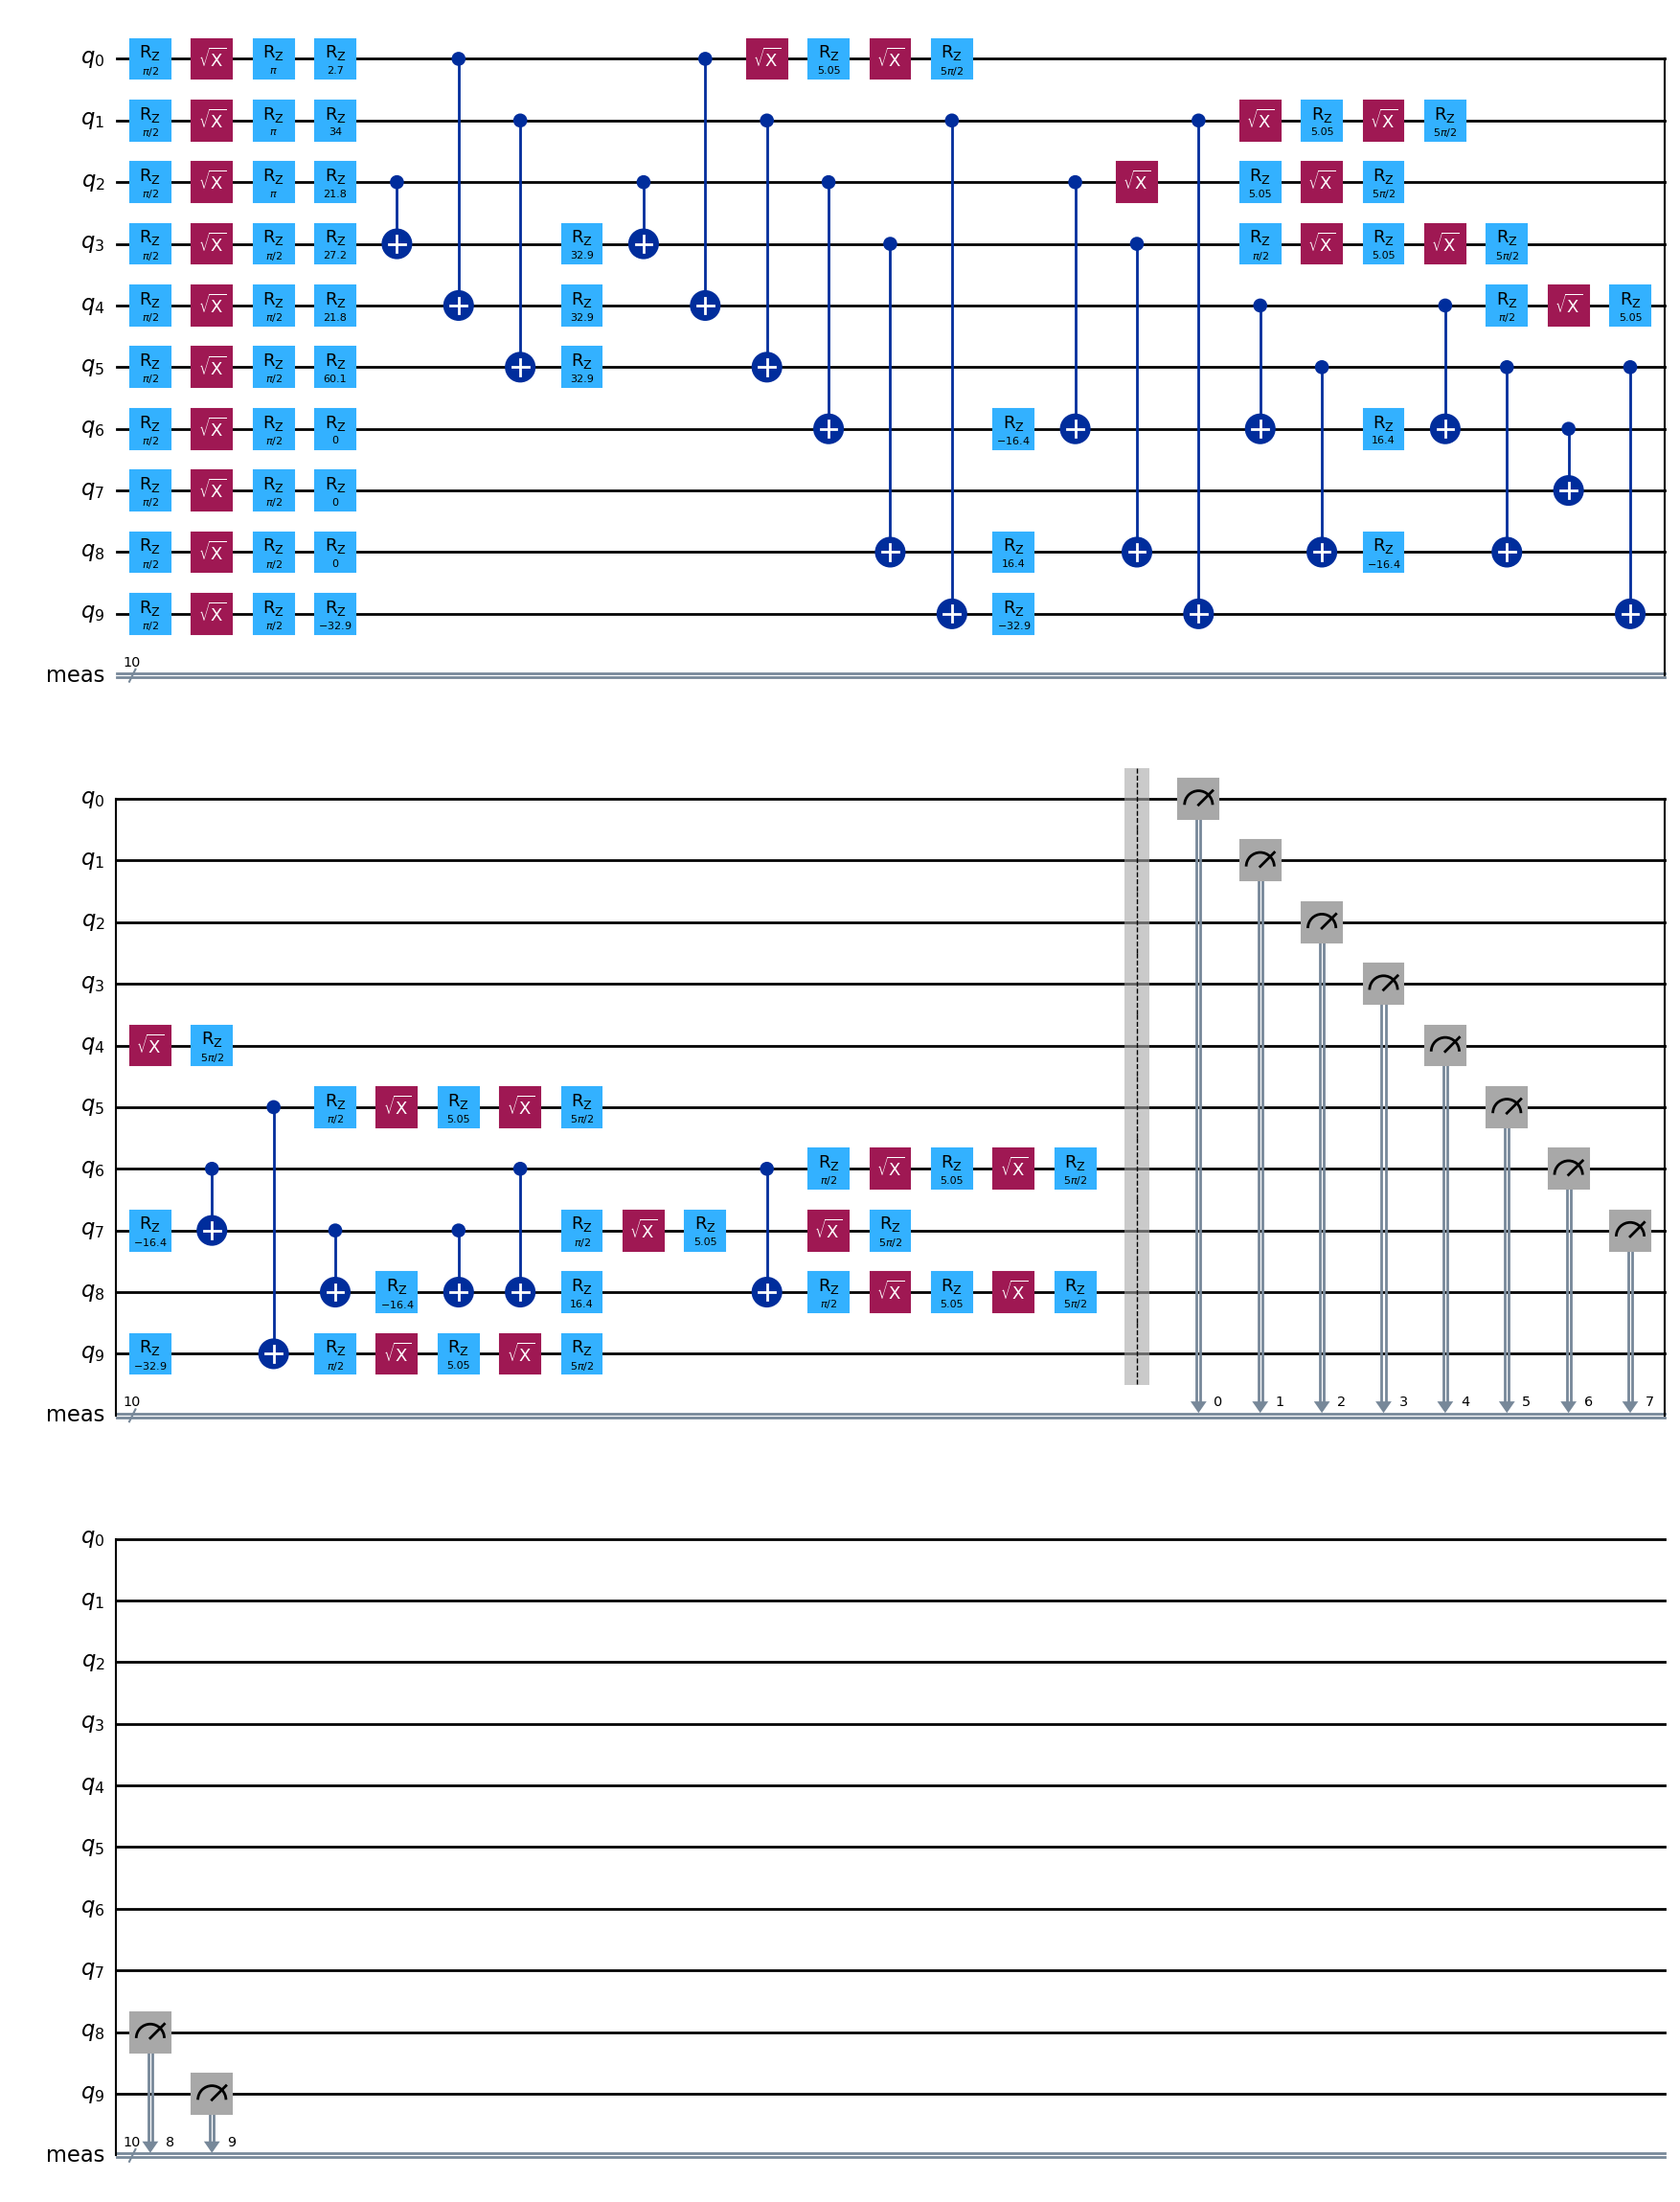

In [ ]:
instance = "tree1.inp"
formulation = "StTopoReduce"
bqm_solving_method = "QAOA_COBYLA"
use_real_device = False
param_dict = {
    "nround": 1
}

draw_circuit(instance, formulation, bqm_solving_method, use_real_device, param_dict)

### Energy distribution visualization

In [ ]:
fig_out_dir = "fig_out"

In [ ]:
def visualize(input_file, output_fig_file="fig.png"):
    with open(input_file, "r") as f:
        data = json.load(f)
        energy_dist = data.get("enrergy_dist", data.get("energy_dist", {}))
        avg_energy = data.get("avg_energy", 0)
        opt_energy = data.get("optimal_energy", 0)

    bin_width = 2500
    binned_data = {}

    for energy_str, count in energy_dist.items():
        try:
            energy = float(energy_str)
            bin_start = math.floor(energy / bin_width) * bin_width

            if bin_start not in binned_data:
                binned_data[bin_start] = 0
            binned_data[bin_start] += count
        except ValueError:
            continue

    sorted_bins = sorted(binned_data.keys())
    heights = [binned_data[b] for b in sorted_bins]

    fig = plt.figure()

    plt.bar(sorted_bins, heights, width=bin_width*0.95, align='edge', edgecolor='black', alpha=0.75)

    plt.xlabel(f"Energy Intervals (Bin width = {bin_width})")
    plt.ylabel("Total Frequency")
    plt.title("QAOA Energy Distribution Histogram")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.axvline(x=avg_energy, color='g', linestyle='--', linewidth=2, label='Average Energy')
    plt.axvline(x=opt_energy, color='r', linewidth=2, label='Optimal Energy')
    plt.legend()

    if 'fig_out_dir' in globals():
        save_path = os.path.join(globals()['fig_out_dir'], output_fig_file)
    else:
        save_path = output_fig_file

    fig.savefig(save_path)
    print(f"Figure saved to: {save_path}")
    plt.show()

Figure saved to: fig_out/StTopoReduce_SPSA.png


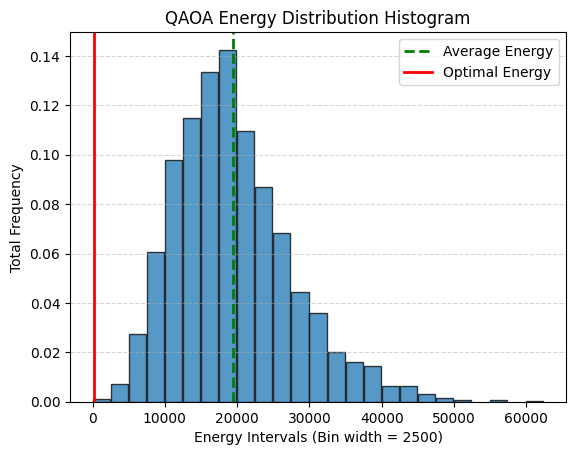

In [ ]:
file = os.path.join(out_dir, "reg4t2.inp_StTopoReduce_QAOA_COBYLA_nround=2_solset.json")
out_img_file = "StTopoReduce_SPSA.png"

visualize(file, out_img_file)